### Goals
---
###### Import, analyze, clean, and preprocess a “real-world” classification dataset.
Select, design, and train a binary classification model of your choosing.
Optimize model training and input data to achieve desired model performance.

In [1]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import tensorflow as tf

# Import input dataset
charity_df = pd.read_csv('charity_data.csv')
charity_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [2]:
# check columns imported correctly
charity_df.dtypes

EIN                        int64
NAME                      object
APPLICATION_TYPE          object
AFFILIATION               object
CLASSIFICATION            object
USE_CASE                  object
ORGANIZATION              object
STATUS                     int64
INCOME_AMT                object
SPECIAL_CONSIDERATIONS    object
ASK_AMT                    int64
IS_SUCCESSFUL              int64
dtype: object

In [3]:
for column in charity_df.columns:
    print(f'Column {column} has {charity_df[column].isnull().sum()} null values.')

Column EIN has 0 null values.
Column NAME has 0 null values.
Column APPLICATION_TYPE has 0 null values.
Column AFFILIATION has 0 null values.
Column CLASSIFICATION has 0 null values.
Column USE_CASE has 0 null values.
Column ORGANIZATION has 0 null values.
Column STATUS has 0 null values.
Column INCOME_AMT has 0 null values.
Column SPECIAL_CONSIDERATIONS has 0 null values.
Column ASK_AMT has 0 null values.
Column IS_SUCCESSFUL has 0 null values.


In [4]:
print(f'Duplicate entries: {charity_df.duplicated().sum()}')

Duplicate entries: 0


In [5]:
# pre-processing first this time; get ready to encode:

# Generate categorical variable list
charity_cat = charity_df.dtypes[charity_df.dtypes == "object"].index.tolist()
charity_cat

['NAME',
 'APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT',
 'SPECIAL_CONSIDERATIONS']

In [6]:
# Check the number of unique values in each column
charity_df[charity_cat].nunique()

NAME                      19568
APPLICATION_TYPE             17
AFFILIATION                   6
CLASSIFICATION               71
USE_CASE                      5
ORGANIZATION                  4
INCOME_AMT                    9
SPECIAL_CONSIDERATIONS        2
dtype: int64

###### 
Target data is the "Is_Successful" column; 1 = yes, 2 = no

Drop EIN & Name

Bin income amounts and ask amounts

In [7]:
charity_df.drop(columns=['NAME', 'EIN'], inplace=True)
charity_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [8]:
charity_df.shape

(34299, 10)

### Pre-process the data
##### - Bin
- Encode
- Standardize

In [9]:
# Check the unique value counts to see if binning is required
app_type_count = charity_df.APPLICATION_TYPE.value_counts()
app_type_count

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T14        3
T25        3
T15        2
T29        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

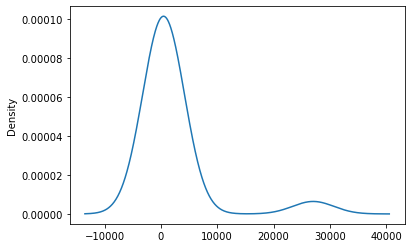

In [10]:
# see range & concentration of values
app_type_count.plot.density()

######  
will bin everything together that is less than 150

In [11]:
# binning values less than 150
app_type_bin = list(app_type_count[app_type_count < 150].index)

# replace the small outliers and place in "OTHER" categors
for i in app_type_bin:
    charity_df.APPLICATION_TYPE = charity_df.APPLICATION_TYPE.replace(i, "OTHER")

charity_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
T9         156
OTHER      120
Name: APPLICATION_TYPE, dtype: int64

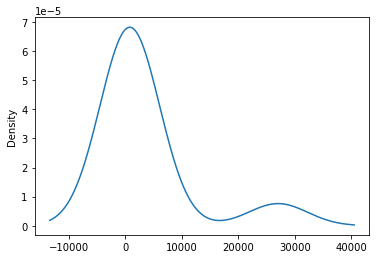

In [12]:
charity_df.APPLICATION_TYPE.value_counts().plot.density()

In [13]:
aff_type_count = charity_df.AFFILIATION.value_counts()
aff_type_count

Independent         18480
CompanySponsored    15705
Family/Parent          64
National               33
Regional               13
Other                   4
Name: AFFILIATION, dtype: int64

Bin Family/Parent, National, Regional & Other together

While less than 10 categorical values, the skew will overweight categories that are more granular -- lumping these back together to not distort the model.

It may be worth dropping this category altogether since the data collection is not particularly well thought out to have such broad categories that provide no real business value.


In [14]:
# binning values less than 150
aff_type_bin = list(aff_type_count[aff_type_count < 100].index)

# replace the small outliers and place in "OTHER" categors
for i in aff_type_bin:
    charity_df.AFFILIATION = charity_df.AFFILIATION.replace(i, "OTHER")

charity_df.AFFILIATION.value_counts()

Independent         18480
CompanySponsored    15705
OTHER                 114
Name: AFFILIATION, dtype: int64

In [15]:
class_count = charity_df.CLASSIFICATION.value_counts()

class_count

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C2170        1
C1728        1
C2561        1
C1820        1
C5200        1
Name: CLASSIFICATION, Length: 71, dtype: int64

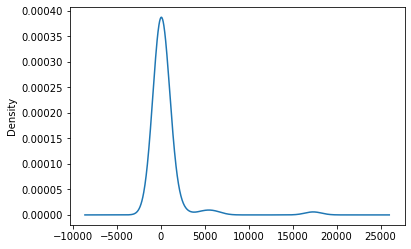

In [16]:
charity_df.CLASSIFICATION.value_counts().plot.density()

In [17]:
# binning values less than 100
class_bin = list(class_count[class_count < 100].index)

# replace the small outliers and place in "OTHER" categors
for i in class_bin:
    charity_df.CLASSIFICATION = charity_df.CLASSIFICATION.replace(i, "OTHER")

charity_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
OTHER      669
C1700      287
C4000      194
C5000      116
C1270      114
C2700      104
Name: CLASSIFICATION, dtype: int64

In [18]:
charity_df.USE_CASE.value_counts()

Preservation     28095
ProductDev        5671
CommunityServ      384
Heathcare          146
Other                3
Name: USE_CASE, dtype: int64

In [19]:
charity_df.ORGANIZATION.value_counts()

Trust           23515
Association     10255
Co-operative      486
Corporation        43
Name: ORGANIZATION, dtype: int64

In [20]:
charity_df.INCOME_AMT.value_counts()

0                24388
25000-99999       3747
100000-499999     3374
1M-5M              955
1-9999             728
10000-24999        543
10M-50M            240
5M-10M             185
50M+               139
Name: INCOME_AMT, dtype: int64

In [21]:
charity_df.SPECIAL_CONSIDERATIONS.value_counts()

N    34272
Y       27
Name: SPECIAL_CONSIDERATIONS, dtype: int64

In [22]:
# Change values to Y = 1, N = 0
charity_df['SPECIAL_CONSIDERATIONS'] = charity_df['SPECIAL_CONSIDERATIONS'].replace(['Y','N'], [0,1])
charity_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,1,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,1,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,1,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,1,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,1,142590,1


In [23]:
charity_df.dtypes

APPLICATION_TYPE          object
AFFILIATION               object
CLASSIFICATION            object
USE_CASE                  object
ORGANIZATION              object
STATUS                     int64
INCOME_AMT                object
SPECIAL_CONSIDERATIONS     int64
ASK_AMT                    int64
IS_SUCCESSFUL              int64
dtype: object

In [24]:
# create new list of columns of data type = object
charity_bin_cat = charity_df.dtypes[charity_df.dtypes == 'object'].index.tolist()
charity_bin_cat

['APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT']

## Encode categorical data

In [25]:
# categorical variables look ready to encode

# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(charity_df[charity_bin_cat]))

# Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names(charity_bin_cat)
encode_df.head()

,APPLICATION_TYPE_OTHER,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,APPLICATION_TYPE_T9,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Merge encoded data columns; drop old

In [26]:
# Merge one-hot encoded features and drop the originals
charity_df = charity_df.merge(encode_df,left_index=True, right_index=True)
charity_df = charity_df.drop(charity_bin_cat,1)
charity_df.head()

,STATUS,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_OTHER,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
0,1,1,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Split the data

In [28]:
# split data for training and testing

# Remove loan status target from features data
y = charity_df.IS_SUCCESSFUL
X = charity_df.drop(columns=["IS_SUCCESSFUL"]).values

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Test various models

#### Deep learning model

Starting with two layers

In [29]:
# build and evaluate deep learning model
# Define the model - deep neural net
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  number_input_features*2
hidden_nodes_layer2 = hidden_nodes_layer1/2

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# check model structure
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 92)                4324      
_________________________________________________________________
dense_1 (Dense)              (None, 46)                4278      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 47        
Total params: 8,649
Trainable params: 8,649
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Compile the Sequential model together and customize metrics
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
804/804 [==============================] - 0s 517us/step - loss: 0.5669 - accuracy: 0.7202
Epoch 2/100
804/804 [==============================] - 0s 501us/step - loss: 0.5520 - accuracy: 0.7308
Epoch 3/100
804/804 [==============================] - 0s 495us/step - loss: 0.5497 - accuracy: 0.7323
Epoch 4/100
804/804 [==============================] - 0s 492us/step - loss: 0.5474 - accuracy: 0.7313
Epoch 5/100
804/804 [==============================] - 0s 491us/step - loss: 0.5455 - accuracy: 0.7339
Epoch 6/100
804/804 [==============================] - 0s 495us/step - loss: 0.5443 - accuracy: 0.7337
Epoch 7/100
804/804 [==============================] - 0s 494us/step - loss: 0.5437 - accuracy: 0.7347
Epoch 8/100
804/804 [==============================] - 0s 491us/step - loss: 0.5433 - accuracy: 0.7352
Epoch 9/100
804/804 [==============================] - 0s 492us/step - loss: 0.5423 - accuracy: 0.7351
Epoch 10/100
804/804 [==============================] - 0s 499us/step - l

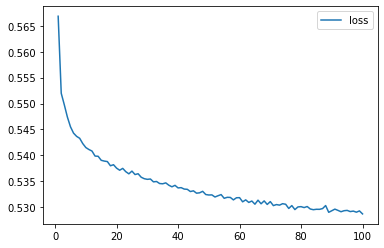

In [34]:
# plot trianing history
training_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history['loss'])+1))

training_df.plot(y='loss')

In [31]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5728 - accuracy: 0.7245
Loss: 0.5728497505187988, Accuracy: 0.7245481014251709


#### Accuracy of 72.5%

###### Tried 50, 100 and 500 epochs; all returned the same value +/- .05% accuracy.

In [33]:
# export the fully trained classification model from the previous cell

# Export model to HDF5 file
nn.save("trained_funding_decision.h5")

### Try sigmoid next 
##### Trying to achieve a binary output; sigmoid is well suited for this

In [35]:
# build and evaluate deep learning model
# Define the model - deep neural net
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  number_input_features*2
hidden_nodes_layer2 = hidden_nodes_layer1/2

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="sigmoid")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="sigmoid"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# check model structure
nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 92)                4324      
_________________________________________________________________
dense_4 (Dense)              (None, 46)                4278      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 47        
Total params: 8,649
Trainable params: 8,649
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Compile the Sequential model together and customize metrics
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
804/804 [==============================] - 0s 519us/step - loss: 0.5907 - accuracy: 0.7074
Epoch 2/100
804/804 [==============================] - 0s 523us/step - loss: 0.5711 - accuracy: 0.7232
Epoch 3/100
804/804 [==============================] - 0s 522us/step - loss: 0.5645 - accuracy: 0.7257
Epoch 4/100
804/804 [==============================] - 0s 530us/step - loss: 0.5583 - accuracy: 0.7282
Epoch 5/100
804/804 [==============================] - 0s 509us/step - loss: 0.5546 - accuracy: 0.7282
Epoch 6/100
804/804 [==============================] - 0s 502us/step - loss: 0.5521 - accuracy: 0.7298
Epoch 7/100
804/804 [==============================] - 0s 501us/step - loss: 0.5511 - accuracy: 0.7294
Epoch 8/100
804/804 [==============================] - 0s 505us/step - loss: 0.5494 - accuracy: 0.7305
Epoch 9/100
804/804 [==============================] - 0s 509us/step - loss: 0.5488 - accuracy: 0.7319
Epoch 10/100
804/804 [==============================] - 0s 500us/step - l

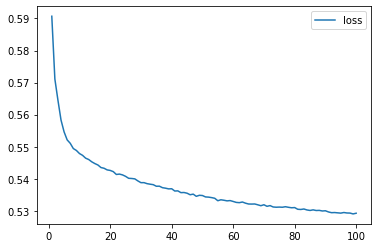

In [37]:
# plot trianing history
training_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history['loss'])+1))

training_df.plot(y='loss')

In [38]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5662 - accuracy: 0.7235
Loss: 0.5661859512329102, Accuracy: 0.723498523235321


In [39]:
# try with sigmoid with 1000 epochs
# Compile the Sequential model together and customize metrics
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=1000)

===================] - 1s 789us/step - loss: 0.5202 - accuracy: 0.7458
Epoch 813/1000
804/804 [==============================] - 0s 615us/step - loss: 0.5203 - accuracy: 0.7460
Epoch 814/1000
804/804 [==============================] - 1s 685us/step - loss: 0.5203 - accuracy: 0.7465
Epoch 815/1000
804/804 [==============================] - 1s 697us/step - loss: 0.5204 - accuracy: 0.7462
Epoch 816/1000
804/804 [==============================] - 1s 686us/step - loss: 0.5202 - accuracy: 0.7463
Epoch 817/1000
804/804 [==============================] - 0s 568us/step - loss: 0.5204 - accuracy: 0.7459
Epoch 818/1000
804/804 [==============================] - 1s 706us/step - loss: 0.5203 - accuracy: 0.7461
Epoch 819/1000
804/804 [==============================] - 1s 733us/step - loss: 0.5203 - accuracy: 0.7464
Epoch 820/1000
804/804 [==============================] - 0s 552us/step - loss: 0.5202 - accuracy: 0.7463
Epoch 821/1000
804/804 [==============================] - 0s 589us/step - loss: 0

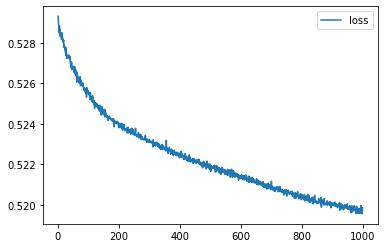

In [40]:
# plot trianing history
training_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history['loss'])+1))

training_df.plot(y='loss')

In [41]:
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.6715 - accuracy: 0.7238
Loss: 0.6714900732040405, Accuracy: 0.7238484025001526


In [42]:
# export the fully trained classification model from the previous cell

# Export model to HDF5 file
nn.save("trained_funding_decision1000.h5")

### Try sigmoid with 100 epochs & 3 neural layers

In [43]:
# build and evaluate deep learning model
# Define the model - deep neural net
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  number_input_features*2
hidden_nodes_layer2 = hidden_nodes_layer1/2
hidden_nodes_layer3 = hidden_nodes_layer1

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="sigmoid")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="sigmoid"))

# Thirs hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="sigmoid"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# check model structure
nn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 92)                4324      
_________________________________________________________________
dense_7 (Dense)              (None, 46)                4278      
_________________________________________________________________
dense_8 (Dense)              (None, 92)                4324      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 93        
Total params: 13,019
Trainable params: 13,019
Non-trainable params: 0
_________________________________________________________________


In [44]:
# try with sigmoid with 100 epochs & 3 layers
# Compile the Sequential model together and customize metrics
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
804/804 [==============================] - 0s 605us/step - loss: 0.5956 - accuracy: 0.7018
Epoch 2/100
804/804 [==============================] - 0s 568us/step - loss: 0.5693 - accuracy: 0.7250
Epoch 3/100
804/804 [==============================] - 0s 590us/step - loss: 0.5619 - accuracy: 0.7260
Epoch 4/100
804/804 [==============================] - 0s 577us/step - loss: 0.5572 - accuracy: 0.7285
Epoch 5/100
804/804 [==============================] - 0s 579us/step - loss: 0.5541 - accuracy: 0.7299
Epoch 6/100
804/804 [==============================] - 0s 584us/step - loss: 0.5532 - accuracy: 0.7294
Epoch 7/100
804/804 [==============================] - 0s 617us/step - loss: 0.5509 - accuracy: 0.7292
Epoch 8/100
804/804 [==============================] - 0s 574us/step - loss: 0.5503 - accuracy: 0.7314
Epoch 9/100
804/804 [==============================] - 0s 587us/step - loss: 0.5499 - accuracy: 0.7299
Epoch 10/100
804/804 [==============================] - 0s 562us/step - l

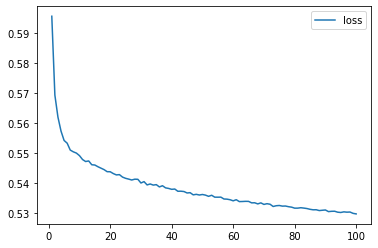

In [45]:
# plot trianing history
training_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history['loss'])+1))

training_df.plot(y='loss')

In [46]:
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5655 - accuracy: 0.7262
Loss: 0.5655080676078796, Accuracy: 0.7261807322502136


### Adding a 3rd layer increased accuracy about a quarter point.  Extending epochs, layers and other training factors are now all in the realm of overfitting the model.  Classifying data in more refince, discrete groups is needed to achieve the objective requirement of 75% accuracy.